In [1]:
!apt-get install swig3.0
!ln -s /usr/bin/swig3.0 /usr/bin/swig
!pip install gymnasium
!pip install gymnasium[classic-control]
!pip install stable-baselines3[extra]
!pip install huggingface_hub
!pip install huggingface-sb3
!pip install river

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig3.0
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,109 kB of archives.
After this operation, 5,555 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig3.0 amd64 3.0.12-2.2ubuntu1 [1,109 kB]
Fetched 1,109 kB in 0s (3,909 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 123588 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-2.2ubuntu1_amd64.deb ...
Unpacking swig3.0 (3.0.12-2.2ubuntu1) ...
Setting up swig3.0 (3.0.12-2.2ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 5.7 MB/s eta 0:00:00
  Installi

In [13]:
import numpy as np
import math
import pandas as pd

import gymnasium as gym
from gymnasium.envs.classic_control.continuous_mountain_car import Continuous_MountainCarEnv
from gymnasium.wrappers import TransformReward, TransformObservation


from huggingface_sb3 import load_from_hub
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import is_wrapped

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import LogNorm

from collections import deque
from typing import Optional, Tuple

import scipy

from river import drift

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load Trained Policy from HuggingFace

In [3]:
checkpoint = load_from_hub(
    repo_id = "sb3/sac-MountainCarContinuous-v0",
    filename = "sac-MountainCarContinuous-v0.zip",
)

model = SAC.load(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sac-MountainCarContinuous-v0.zip:   0%|          | 0.00/238k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object learning_rate. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(


## Create Drifted Environment Class

In [4]:
class Continuous_MountainCarEnvWithWind(Continuous_MountainCarEnv):
  def __init__(self, render_mode: Optional[str] = None, goal_velocity=0, wind_direction="left",
               windpower=0.35):
    super().__init__(render_mode, goal_velocity)
    self.wind_direction = wind_direction
    self.windpower = windpower

  def step(self, action: np.ndarray):
        position = self.state[0]
        velocity = self.state[1]
        force = min(max(action[0], self.min_action), self.max_action)

        windforce = max(np.random.normal(self.windpower, 0.015),0.)

        #velocity += force * self.power - 0.0025 * math.cos(3 * position)

        if self.wind_direction == "left":
          # Left Wind
          velocity += (force-windforce) * self.power - 0.0025 * math.cos(3 * position)
        else:
          # Right Wind
          velocity += (force+windforce) * self.power - 0.0025 * math.cos(3 * position)


        if velocity > self.max_speed:
            velocity = self.max_speed
        if velocity < -self.max_speed:
            velocity = -self.max_speed
        position += velocity
        if position > self.max_position:
            position = self.max_position
        if position < self.min_position:
            position = self.min_position
        if position == self.min_position and velocity < 0:
            velocity = 0

        # Convert a possible numpy bool to a Python bool.
        terminated = bool(
            position >= self.goal_position and velocity >= self.goal_velocity
        )

        reward = 0
        if terminated:
            reward = 100.0
        reward -= math.pow(action[0], 2) * 0.1

        self.state = np.array([position, velocity], dtype=np.float32)

        if self.render_mode == "human":
            self.render()
        # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
        return self.state, reward, terminated, False, {}

## Create Environments

In [6]:
env0 = Continuous_MountainCarEnv() # Training Environment
env1 = Continuous_MountainCarEnv() # Undrifted Production Environment
env2 = Continuous_MountainCarEnvWithWind(wind_direction="left",
                                         windpower=0.35) # Drifted Production Environment

## Test Policy Performance in Environments

In [7]:
evaluate_policy(model, env1, n_eval_episodes=500, deterministic=True)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(94.58165547841077, 1.1674491365327337)

In [8]:
evaluate_policy(model, env2, n_eval_episodes=500, deterministic=True)

(93.8276473325624, 2.1604947490202697)

## Environment Drift Detection

In [9]:
rewards_production = []

env1_step = 3000
env2_step = 3000


total_step = env1_step + env2_step

n_past_steps_to_store = 500
replay_buffer = deque([], maxlen=n_past_steps_to_store)

env_current = env1
obs_t, _ = env_current.reset() # Initialize the environment

for t in range(1, total_step+1):

  if t%500 == 0:
   print(f"step {t}")

  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env_current.step(action_t)
  replay_buffer.append([obs_t, action_t, obs_tplus1, r_tplus1, t])

  rewards_production.append(r_tplus1)

  done = terminated or truncated

  obs_t = obs_tplus1

  if done:
    obs_t, _ = env_current.reset()

  if t==env1_step: ## Environment Drift Happens
    env_current = env2
    obs_t, _ = env_current.reset()

step 500
step 1000
step 1500
step 2000
step 2500
step 3000
step 3500
step 4000
step 4500
step 5000
step 5500
step 6000


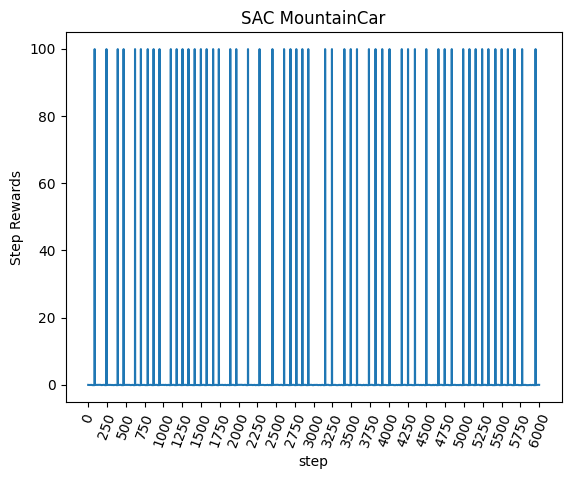

In [10]:
plt.plot(np.array(rewards_production))
plt.xticks(np.arange(0,6001, 250), rotation=70)
#plt.axvline(x=3000, label="Environment Drift", color='red')
plt.xlabel("step")
plt.ylabel("Step Rewards")
#plt.legend()
plt.title("SAC MountainCar")
plt.show()

### Environment Drift Detection with ProbCUSUM

In [14]:
class CusumMeanDetector():
  def __init__(self, mu_ref, sigma_ref, obs_ref, p_limit=0.01) -> None:
    self._mu_ref = mu_ref
    self._sigma_ref = sigma_ref
    self._p_limit = p_limit

    self._reset(obs_ref)

  def _reset(self, obs_ref) -> None:
    self.current_t = len(obs_ref)
    self.current_obs = obs_ref.copy()
    #self.mu_current = self._mu_ref
    #self.sigma_current = self._sigma_ref

  def _update_data(self, y:float) -> None:
    self.current_t += 1
    self.current_obs.append(y)

  def _get_pvalue(self, y, alternative="two-sided") -> float:
    assert alternative in {"two-sided", "greater", "less"}
    pcum = scipy.stats.norm.cdf(y, loc=0., scale=1.)
    if alternative == "two-sided":
      p = 2*(1-pcum)
    if alternative == "greater":
      p = 1-pcum
    if alternative == "less":
      p = pcum
    return p

  def _check_for_changepoint(self, alternative) -> Tuple[float, bool]:
    standardized_sum = np.sum(np.array(self.current_obs)-self._mu_ref)/(self._sigma_ref*self.current_t**0.5)
    p = self._get_pvalue(standardized_sum, alternative)
    return p, p < self._p_limit


  def predict_next(self, y, alternative="two-sided") -> Tuple[float, bool]:
    self._update_data(y)
    p, is_changepoint = self._check_for_changepoint(alternative)
    return p, is_changepoint

In [15]:
# Environment Drift Detection with prob-CUSUM
env0_steps = 4000
rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  rewards_reference.append(r_tplus1)
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()

drift_detector = CusumMeanDetector(mu_ref=mu_ref,
                                   sigma_ref=sigma_ref,
                                   obs_ref=rewards_reference_window,
                                   p_limit = p_limit)


false_alarms = 0
delay = 4000

for i,val in enumerate(rewards_production):
  #drift_detector.add_data_point(val)
  p_value, drift_detected = drift_detector.predict_next(val, alternative="less")
  if drift_detected:
    print(f"Drift Detected at: {i} with value: {val}")
    rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()
    drift_detector._reset(rewards_reference_window)
    if i < 3000:
      false_alarms+=1
    if i >= 3000:
      delay = i-3000
      break

print(f"False Positives: {false_alarms}, Delay: {delay}")

False Positives: 0, Delay: 4000


In [16]:
# Environment Drift Detection with CUSUM
env0_steps = 4000

episode_length = 200
episode_deque = deque([], maxlen=episode_length)

rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  episode_deque.append(r_tplus1)
  if len(episode_deque)==episode_length:
      rewards_reference.append(np.mean(episode_deque))
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()



mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()

drift_detector = CusumMeanDetector(mu_ref=mu_ref,
                                   sigma_ref=sigma_ref,
                                   obs_ref=rewards_reference_window,
                                   p_limit = p_limit)

false_alarms = 0
delay = 4000


for i,val in enumerate(rewards_production):
  #drift_detector.add_data_point(val)
  episode_deque.append(val)
  val_avg = np.mean(episode_deque)
  p_value, drift_detected = drift_detector.predict_next(val_avg, alternative="less")
  if drift_detected:
    print(f"Drift Detected at: {i} with value: {val_avg}")
    rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()
    drift_detector._reset(rewards_reference_window)
    if i < 3000:
      false_alarms+=1
    if i >= 3000:
      delay = i-3000
      break

print(f"False Positives: {false_alarms}, Delay: {delay}")

Drift Detected at: 215 with value: 0.46304779194068496
Drift Detected at: 306 with value: 0.4657366821371005
Drift Detected at: 317 with value: 0.46478358100422246
Drift Detected at: 343 with value: 0.4593867222623737
Drift Detected at: 362 with value: 0.4579032232674499
Drift Detected at: 382 with value: 0.45553213623792765
Drift Detected at: 463 with value: 0.4514181501703598
Drift Detected at: 691 with value: 0.45548039351294306
Drift Detected at: 4729 with value: 0.44381872244852244
False Positives: 8, Delay: 1729


### Page-Hinkley

In [17]:
ph = drift.PageHinkley(mode="down", delta=0.005)

env0_steps = 4000
rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  rewards_reference.append(r_tplus1)
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
#rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()


false_alarms = 0
delay = 4000

rewards_production_norm = (rewards_production-mu_ref)/sigma_ref

for i, val in enumerate(rewards_production_norm):
  ph.update(val)
  if ph.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

False Alarms: 0, Delay: 4000


In [18]:
ph = drift.PageHinkley(mode="down", delta=0.005)

env0_steps = 4000

episode_length = 200
episode_deque = deque([], maxlen=episode_length)

rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  episode_deque.append(r_tplus1)
  if len(episode_deque)==episode_length:
      rewards_reference.append(np.mean(episode_deque))
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()



mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)



rewards_production_average = []

for reward in rewards_production:
  #drift_detector.add_data_point(val)
  episode_deque.append(reward)
  reward_average = np.mean(episode_deque)
  rewards_production_average.append(reward_average)

rewards_production_average_norm = (rewards_production_average-mu_ref)/sigma_ref

false_alarms = 0
delay = 4000

for i, val in enumerate(rewards_production_average_norm):
  ph.update(val)
  if ph.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 160, input value: -1.5085603956215463
Change detected at index 1167, input value: -1.5329365962157793
Change detected at index 2201, input value: -1.497738358532074
Change detected at index 2435, input value: -1.554340633518029
Change detected at index 2565, input value: -1.5086837597881058
Change detected at index 3068, input value: -1.5329603933757454
False Alarms: 5, Delay: 68


### ADWIN

In [19]:
adwin = drift.ADWIN()

env0_steps = 4000
rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  rewards_reference.append(r_tplus1)
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
#rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()


false_alarms = 0
delay = 4000

rewards_production_norm = (rewards_production-mu_ref)/sigma_ref

for i, val in enumerate(rewards_production_norm):
  adwin.update(val)
  if adwin.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

False Alarms: 0, Delay: 4000


In [20]:
adwin = drift.ADWIN()

env0_steps = 4000

episode_length = 200
episode_deque = deque([], maxlen=episode_length)

rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  episode_deque.append(r_tplus1)
  if len(episode_deque)==episode_length:
      rewards_reference.append(np.mean(episode_deque))
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()



mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)


rewards_production_average = []

for reward in rewards_production:
  #drift_detector.add_data_point(val)
  episode_deque.append(reward)
  reward_average = np.mean(episode_deque)
  rewards_production_average.append(reward_average)

rewards_production_average_norm = (rewards_production_average-mu_ref)/sigma_ref

false_alarms = 0
delay = 4000

for i, val in enumerate(rewards_production_average_norm):
  adwin.update(val)
  if adwin.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 287, input value: -1.488907737162634
Change detected at index 2207, input value: -1.501763369493391
Change detected at index 2335, input value: -1.5237913654381625
Change detected at index 2687, input value: -1.519022604784923
Change detected at index 3103, input value: -1.550842239746337
False Alarms: 4, Delay: 103


### KSWIN

In [21]:
kswin = drift.KSWIN()

env0_steps = 4000
rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  rewards_reference.append(r_tplus1)
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
#rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()


false_alarms = 0
delay = 4000

rewards_production_norm = (rewards_production-mu_ref)/sigma_ref

for i, val in enumerate(rewards_production_norm):
  kswin.update(val)
  if kswin.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 110, input value: -0.09099955077779313
Change detected at index 233, input value: -0.09734991170514318
Change detected at index 340, input value: -0.09667500296842628
Change detected at index 440, input value: -0.09333895234666023
Change detected at index 540, input value: -0.09093603367014295
Change detected at index 640, input value: -0.09325703829853722
Change detected at index 740, input value: -0.08803922660878412
Change detected at index 840, input value: -0.09435728848498527
Change detected at index 942, input value: -0.09734991170514318
Change detected at index 1044, input value: -0.09707539508199385
Change detected at index 1144, input value: -0.09035318869753599
Change detected at index 1247, input value: -0.09734991170514318
Change detected at index 1362, input value: -0.08976312985714055
Change detected at index 1462, input value: -0.08900811904166793
Change detected at index 1568, input value: -0.09734991170514318
Change detected at index 1668, inp

In [22]:
kswin = drift.KSWIN()

env0_steps = 4000

episode_length = 200
episode_deque = deque([], maxlen=episode_length)

rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  episode_deque.append(r_tplus1)
  if len(episode_deque)==episode_length:
      rewards_reference.append(np.mean(episode_deque))
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()



mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)


rewards_production_average = []

for reward in rewards_production:
  #drift_detector.add_data_point(val)
  episode_deque.append(reward)
  reward_average = np.mean(episode_deque)
  rewards_production_average.append(reward_average)

rewards_production_average_norm = (rewards_production_average-mu_ref)/sigma_ref

false_alarms = 0
delay = 4000

for i, val in enumerate(rewards_production_average_norm):
  kswin.update(val)
  if kswin.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 199, input value: -1.5392977268930563
Change detected at index 299, input value: -1.5175241577079241
Change detected at index 606, input value: -1.5422620862395087
Change detected at index 2108, input value: -1.52935893871699
Change detected at index 2208, input value: -1.5348772798304056
Change detected at index 2408, input value: -1.5940989438054578
Change detected at index 2508, input value: -1.5687979032140775
Change detected at index 3118, input value: -1.5669620719819721
False Alarms: 7, Delay: 118
